# $\mathrm{NO_3}$

In [1]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 

using KernelFunctions
using ParameterHandling

In [2]:
include("./utils.jl")

predict_logσ_wΔ

In [3]:
h5_path = "../../data/photolysis_data.h5" 
species = "NO3" 
nice_name = "NO₃"

λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println("max λ: ", maximum(λs))
println("min λ: ", minimum(λs))

max λ: 794.221
min λ: 200.0


In [4]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [5]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
# df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=0.0, λ_ub=1200.0)
println(nrow(df))
describe(df)

22123


4×7 DataFrame
 Row │ variable   mean           min          median       max         nmissin ⋯
     │ Symbol     Float64        Real         Float64      Real        Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ          602.89         220.0        598.6        794.221             ⋯
   2 │ σ            2.14509e-18    5.146e-22    1.503e-18    2.28e-17
   3 │ T          294.767        294.0        294.0        300.0
   4 │ source_id   22.0123         2           20.0         45
                                                               2 columns omitted

In [6]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

savefig("O3_p2.png")

display(p2)

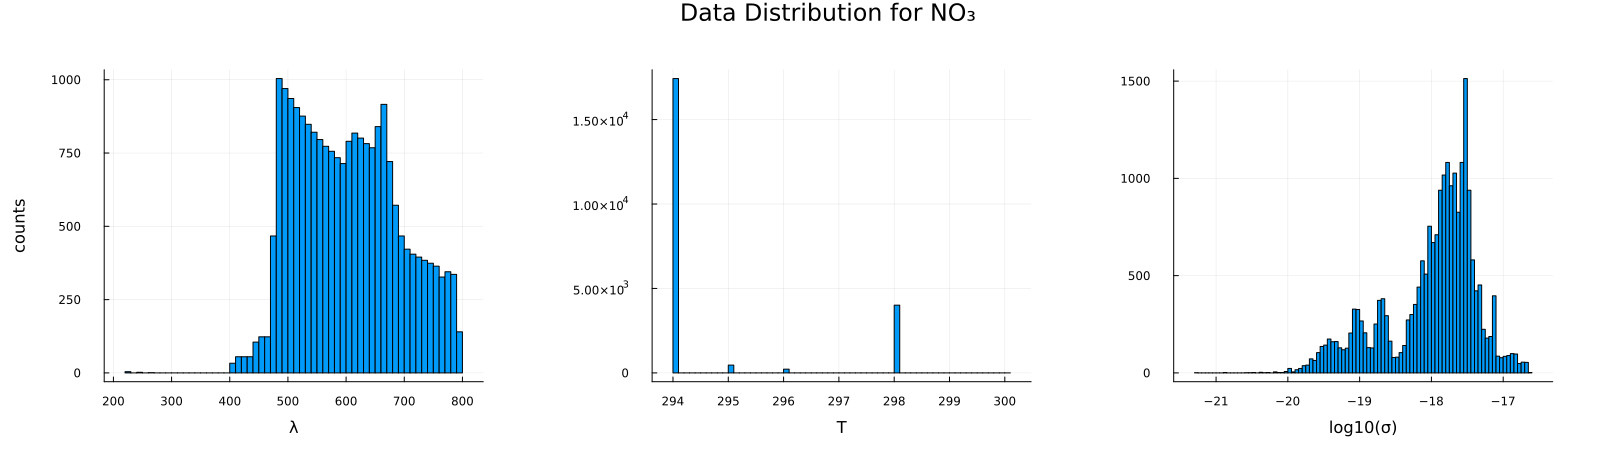

In [7]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="",)
p2 = histogram(df.T, xlabel="T", label="",)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="",)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450),  margin=10Plots.mm, plot_title="Data Distribution for $(nice_name)")

In [8]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [9]:
# deal with identical wavelength records 

gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

20259×3 DataFrame
   Row │ λ        σ            T       
       │ Float64  Float64      Float64 
───────┼───────────────────────────────
     1 │  654.01  1.25e-18       294.0
     2 │  655.78  1.24e-18       294.0
     3 │  657.8   2.0e-18        294.0
     4 │  658.76  3.39e-18       294.0
     5 │  659.8   6.2e-18        294.0
     6 │  660.81  1.03e-17       294.0
     7 │  661.82  1.2e-17        294.0
     8 │  662.78  1.17e-17       294.0
     9 │  663.81  1.03e-17       294.0
    10 │  664.85  8.08e-18       294.0
    11 │  665.81  7.38e-18       294.0
   ⋮   │    ⋮          ⋮          ⋮
 20250 │  692.0   7.93245e-20    298.0
 20251 │  692.2   7.88595e-20    298.0
 20252 │  692.4   7.84575e-20    298.0
 20253 │  692.6   8.07806e-20    298.0
 20254 │  692.8   8.2515e-20     298.0
 20255 │  693.2   8.78048e-20    298.0
 20256 │  693.4   8.60858e-20    298.0
 20257 │  693.6   8.8373e-20     298.0
 20258 │  693.8   8.644e-20      298.0
 20259 │  652.0   8.41e-19       300.0
                     20238 rows omitted

In [20]:
# here is where we would do representative subsampling if there are too many records (> 2000) 
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
T_idxs = representative_rand_sample(df_unique.λ, 5, 1000)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 



idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs, σ_idxs)))


df_sampled = df_unique[idxs_res, :]


max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

println(nrow(df_sampled))
describe(df_sampled)

2017


3×7 DataFrame
 Row │ variable  mean           min          median         max           nmis ⋯
     │ Symbol    Float64        Float64      Float64        Float64       Int6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         642.954        220.0        658.388        794.221            ⋯
   2 │ σ           2.52923e-18    5.146e-22    7.99956e-19    2.2103e-17
   3 │ T         294.569        294.0        294.0          298.0
                                                               2 columns omitted

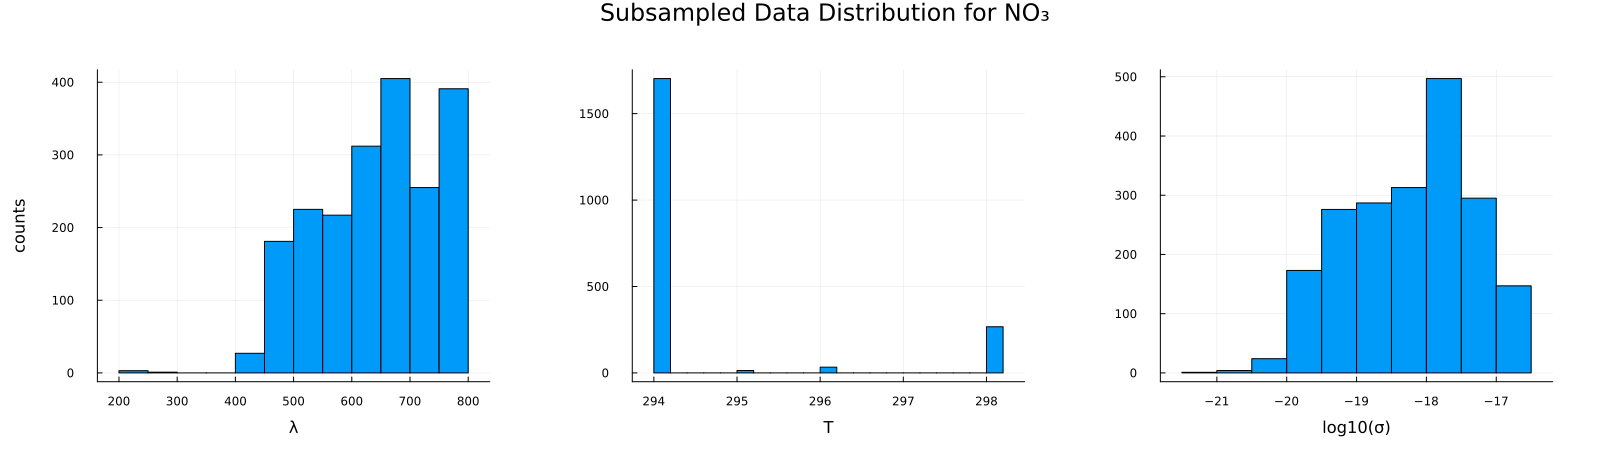

In [21]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

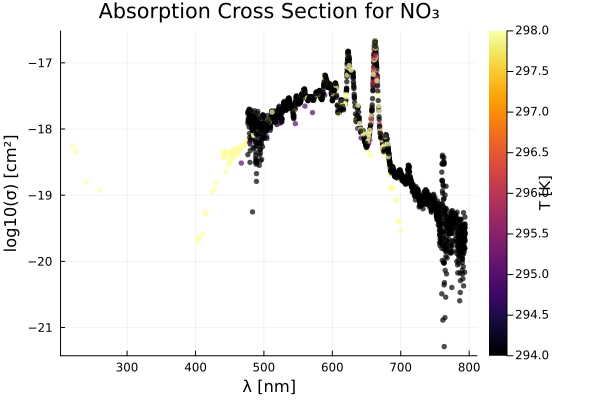

In [22]:
# visualize pre-processed data: 
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

In [23]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1916


In [29]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

# gpr = GPR(σ²=0.00001)

θ_init = (σf² = positive(5.0), ℓ = positive(0.1))
gpr = GPR(
    θ_init=θ_init,
    σ²=20.0
)
# gpr = GPR(σ²=10.0)

mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0     1.725343e+04     8.904625e+03
 * time: 0.00015020370483398438
     1     1.198132e+04     9.495498e+02
 * time: 9.212920188903809
     2     9.026010e+03     5.208390e+03
 * time: 13.108780145645142
     3     3.873411e+03     5.689085e+03
 * time: 19.214760065078735
     4     3.468581e+03     5.355792e+03
 * time: 25.015282154083252
     5     9.356525e+02     7.527788e+02
 * time: 26.822192192077637
     6     7.573849e+02     3.285751e+02
 * time: 28.487666130065918
     7     4.242656e+02     7.187226e+02
 * time: 32.095426082611084
     8     1.249274e+02     6.524109e+02
 * time: 33.846482038497925
     9    -4.623234e+01     2.535040e+02
 * time: 35.084794998168945
    10    -1.486345e+02     1.529568e+03
 * time: 36.811952114105225
    11    -1.955873e+02     1.678047e+03
 * time: 41.17196011543274
    12    -2.207020e+02     4.029186e+02
 * time: 42.36651301383972
    13    -2.608623e+02     7.095693e+02
 * time: 44.18816018

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @649 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @589 ⏎ AbstractVector{Continuous}


In [30]:
rpt = report(mach)
println(rpt)

y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

(summary = "L-BFGS", minimizer = [4.55030962847401, 0.9046179727440605, -3.4564696915758737], minimum = -274.97906545006106, iterations = 779, converged = false)


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/QZRtR/src/args.jl:1548


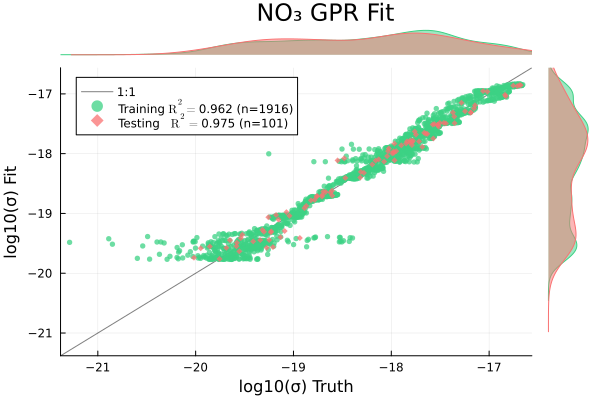

In [31]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)

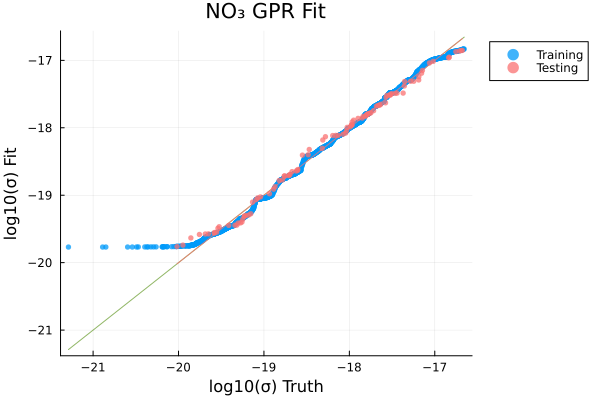

In [33]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


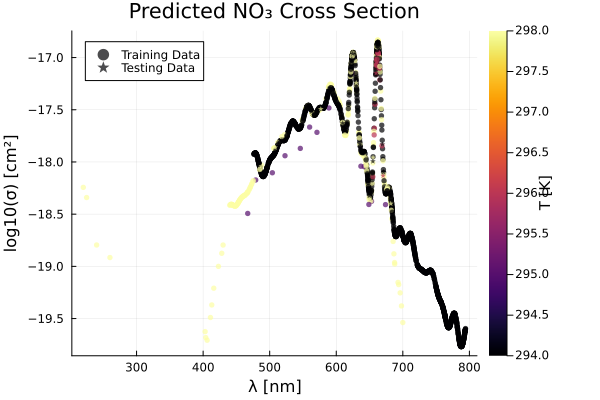

In [34]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)

220.0
794.221


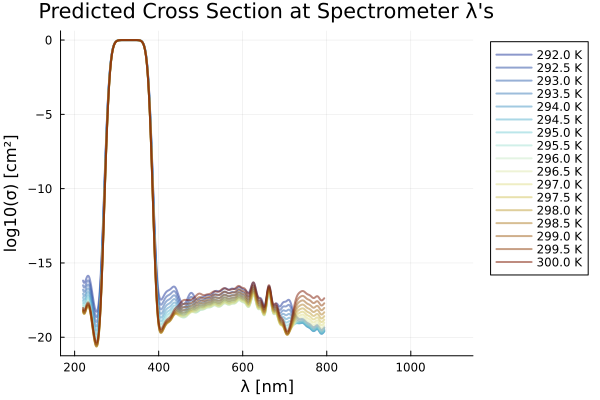

In [36]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

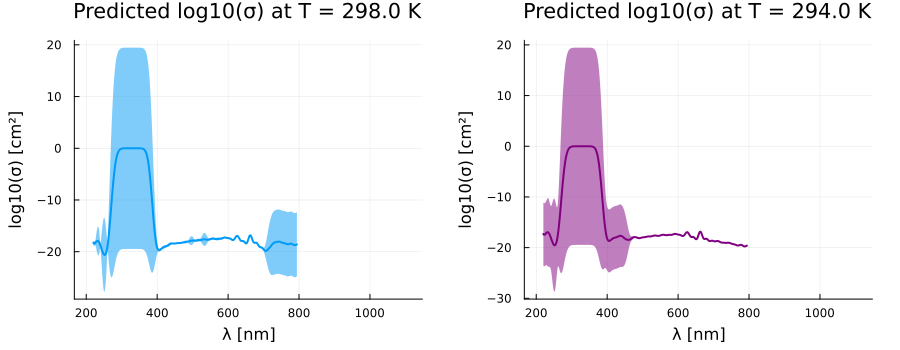

In [41]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 